To do:
    -class 
    -adjacency matrix (done)
    -method to compute weights  (done)
    -tiebreaker (done)
    -distance method
    -add
    -remove 
    

In [1]:
from FaceRec import Face_Recognition
from database import Database
%matplotlib notebook
f = Face_Recognition()

File already exists:
	/Users/megankaye/Desktop/BeaverWorks/Work/Week2/DlibModels/dlib_models/dlib_face_recognition_resnet_model_v1.dat
File already exists:
	/Users/megankaye/Desktop/BeaverWorks/Work/Week2/DlibModels/dlib_models/shape_predictor_68_face_landmarks.dat


In [2]:
from dlib_models import download_model, download_predictor, load_dlib_models
download_model()
download_predictor()
from dlib_models import models
from pathlib import Path
import skimage.io as io
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

File already exists:
	/Users/megankaye/Desktop/BeaverWorks/Work/Week2/DlibModels/dlib_models/dlib_face_recognition_resnet_model_v1.dat
File already exists:
	/Users/megankaye/Desktop/BeaverWorks/Work/Week2/DlibModels/dlib_models/shape_predictor_68_face_landmarks.dat


In [3]:
load_dlib_models()
face_detect = models["face detect"]
face_rec_model = models["face rec"]
shape_predictor = models["shape predict"]

In [4]:
def plot_graph(graph, adj):
    """ Use the package networkx to produce a diagrammatic plot of the graph, with
        the nodes in the graph colored according to their current labels.

        Note that only 20 unique colors are available for the current color map,
        so common colors across nodes may be coincidental.

        Parameters
        ----------
        graph : Tuple[Node, ...]
            The graph to plot
            
        adj : numpy.ndarray, shape=(N, N)
            The adjacency-matrix for the graph. Nonzero entries indicate
            the presence of edges.

        Returns
        -------
        Tuple[matplotlib.fig.Fig, matplotlib.axis.Axes]
            The figure and axes for the plot."""
    import networkx as nx
    import numpy as np
    import matplotlib.cm as cm
    import matplotlib.pyplot as plt

    g = nx.Graph()
    for n, node in enumerate(graph):
        g.add_node(n)

    g.add_edges_from(zip(*np.where(np.triu(adj) > 0)))
    pos = nx.spring_layout(g)

    color = list(iter(cm.Vega20b(np.linspace(0, 1, len(set(i.label for i in graph))))))
    color_map = dict(zip(sorted(set(i.label for i in graph)), color))
    colors = [color_map[i.label] for i in graph]
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, nodelist=range(len(graph)), node_color=colors)
    nx.draw_networkx_edges(g, pos, ax=ax, edgelist=g.edges())
    return fig, ax

def read_image_files(folder_path):
        """
        Parameters
        ----------
        folder_path : the folderpath to read the image files from 
        
        """
        img_list = []
        name_list = []
        p = Path(folder_path)
        pics = sorted(p.glob('*'))
        for i in range(len(pics)):
            name_list.append(pics[i].name[:-5])
            img_list.append(file_read(pics[i]))
        return img_list, name_list

def file_read(file_id):
    """ reads a file on a computer
        Parameters
        ----------
        file_id : the filepath to read the file from """
    img_array = io.imread(file_id)
    if (img_array.shape[2] == 4):
        img_array = img_array[:, :, :3]
    return img_array

In [240]:
import numpy as np
class WhisperDatabase:
    def __init__(self, listData, labels):
        """ 
            Parameters
            ----------
            listData: list
                list of images or data
            labels: list
                truth values for all the images in listData
        """
        
        self.size = len(listData)
        self.nodes = list()
        for image, label in zip(listData, labels):
            desc_list = []
            detections = list(face_detect(image, 1))
            for i in range(len(detections)):
                shape = shape_predictor(image, detections[i])
                desc = np.array(face_rec_model.compute_face_descriptor(image, shape))
                length = len(self.nodes)
                self.nodes.append(Node(length, desc, truth=label))
        
        self.adj = self.adj_matrix(self.nodes)
                        
    def whisper_pass(self):
        """iterates through the nodes in self.nodes, attaching weights 
        to each edge. higher weights """
        for node in self.nodes:
            if node.neighbors == []:
                pass
            else:
                node.label = self.compute_edge(node)
            
    def adj_matrix(self, node_list):
        adj = np.zeros([len(node_list),len(node_list)])
        for i in range(0,len(node_list)):
            for j in range(0,len(node_list)):
                if i == j:
                    adj[i,j] = 0
                elif np.sqrt(np.sum((node_list[i].descriptor-node_list[j].descriptor)**2)) < .3:
                    adj[i,j] = 0
                else:
                    adj[i,j] = 1/(np.sqrt(np.sum((node_list[i].descriptor-node_list[j].descriptor)**2)))**2
        return adj
    
    def compute_edge(self, node):
        weights = {}
        for n in node.neighbors:
            v = np.sqrt(np.sum((node.descriptor-self.nodes[n].descriptor)**2))
            if v < .55:
                w = 1/v**2
                if self.nodes[n].label in weights:
                    weights[self.nodes[n].label] += w
                else:
                    weights[self.nodes[n].label] = w
        print(weights)
        return max(weights, key=weights.get)

    def pairwise(self):
        LT, LTT, LLT = 0,0,0;
        for node in self.nodes:
            for n in node.neighbors:
                print(self.nodes[n].label,self.nodes[n].truth,node.label,node.truth)
                if node.label == self.nodes[n].label and node.truth == self.nodes[n].truth:
                    LT += 1;
                elif node.label != self.nodes[n].label and node.truth == self.nodes[n].truth:
                    LLT += 1;
                elif node.label == self.nodes[n].label and node.truth != self.nodes[n].truth:
                    LTT += 1;
        return (LT/(LT+LLT),LT/(LT+LLT))
            
    def create_neighbors(self, threshold=.45):
        for i in range(len(self.nodes)):
            self.nodes[i].neighbors = []
            for x in range(len(self.nodes)):
                if i != x:
                    dist = np.sqrt(np.sum((self.nodes[i].descriptor - self.nodes[x].descriptor) ** 2))
                    if dist < threshold:
                        self.nodes[i].neighbors.append(self.nodes[x].id)

In [241]:
    """ creates neighbors, pairing nodes based on images of closest descriptor vectors using Euclidean distance algorithm

        Parameters
        ----------
        threshold : the highest Euclidean distance sum of which nodes can still be considered to be connected; 
    images with higher Euclidean distances are not connected """

' creates neighbors, pairing nodes based on images of closest descriptor vectors using Euclidean distance algorithm\n\n    Parameters\n    ----------\n    threshold : the highest Euclidean distance sum of which nodes can still be considered to be connected; \nimages with higher Euclidean distances are not connected '

In [242]:
class Node:
    """ Describes a node in a graph, and the edges connected
        to that node."""

    def __init__(self, ID, descriptor, truth=None, neighbors=None, file_path=None):
        """ Parameters
            ----------
            ID : int
                A unique identifier for this node. Should be a
                value in [0, N-1], if there are N nodes in total.

            neighbors : Sequence[int]
                The node-IDs of the neighbors of this node.

            descriptor : numpy.ndarray
                The (128,) descriptor vector for this node's picture

            truth : Optional[str]
                If you have truth data, for checking your clustering algorithm,
                you can include the label to check your clusters at the end.

                If this node corresponds to a picture of Ryan, this truth
                value can just be "Ryan"

            file_path : Optional[str]
                The file path of the image corresponding to this node, so
                that you can sort the photos after you run your clustering
                algorithm

            """
        self.id = ID

        # The node's label is initialized with the node's ID value at first,
        # this label is then updated during the whispers algorithm
        self.label = ID

        # (n1_ID, n2_ID, ...)
        # The IDs of this nodes neighbors. Empty if no neighbors
        if neighbors is None:
            neighbors = []
        self.neighbors = neighbors
        self.descriptor = descriptor

        self.truth = truth
        self.file_path = file_path
    

In [243]:
f = read_image_files("Vectors/pictures")

In [244]:
w = WhisperDatabase(f[0], f[1])

In [245]:
w.create_neighbors()

In [246]:
w.whisper_pass()

{2: 6.9297921770812172}
{2: 6.9297921770812172}
{5: 10.942171715567673, 6: 7.0696633384043563, 7: 9.3971712064708619}
{5: 10.942171715567673, 6: 8.4890961456560543, 7: 8.7281828494921783}
{5: 15.55875948406041, 7: 7.6982377440172352}
{5: 25.823591799980274}
{11: 6.991662952949449}
{11: 6.991662952949449}


In [247]:
w.pairwise()

2 megan 2 megan
2 megan 2 megan
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
5 melanie 5 melanie
11 ryan 11 ryan
11 ryan 11 ryan


(1.0, 1.0)

<IPython.core.display.Javascript object>


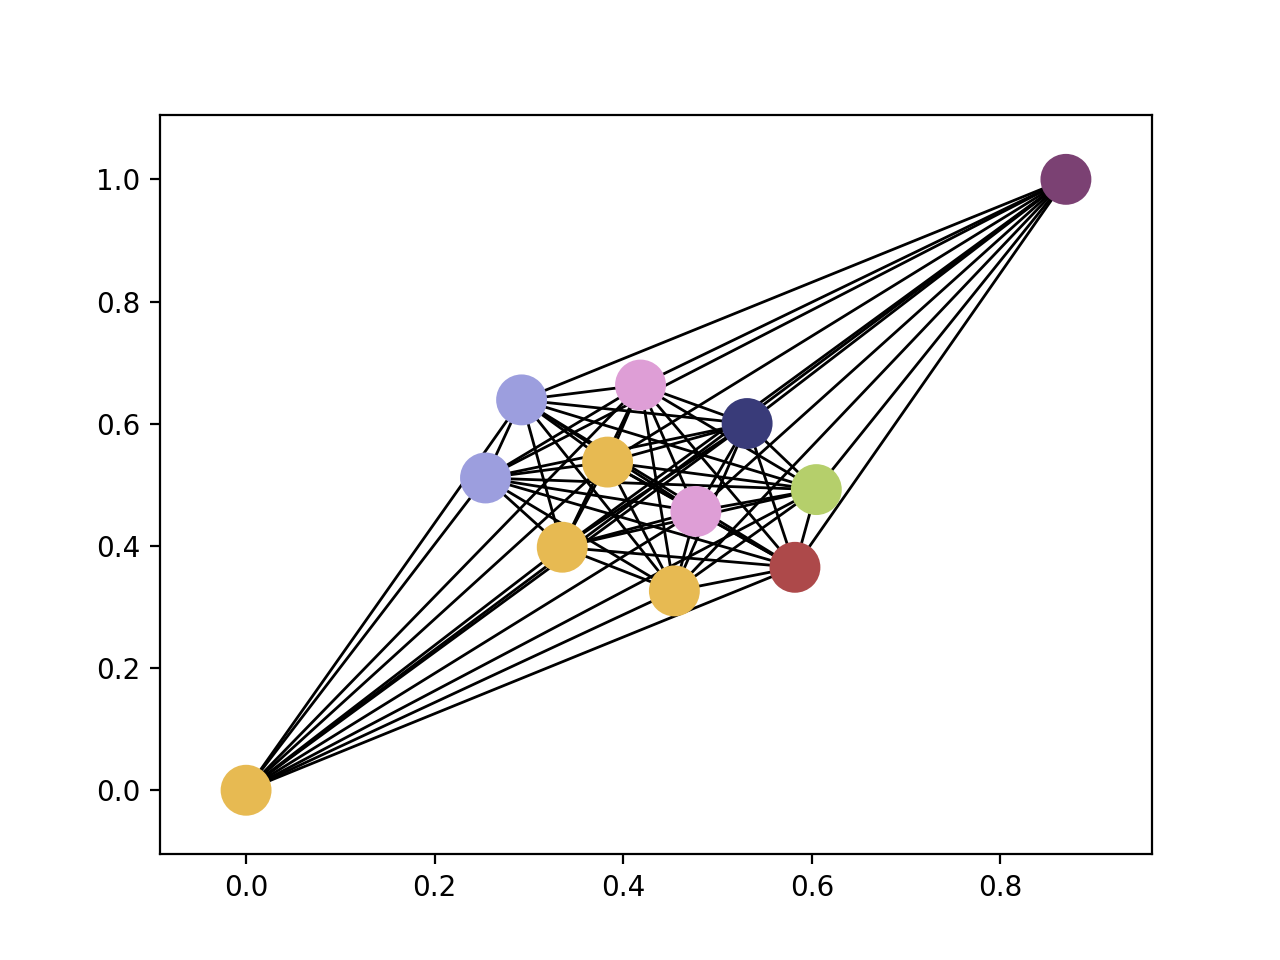

(<matplotlib.figure.Figure at 0x11d980e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11d9f32b0>)

In [248]:
plot_graph(tuple(w.nodes),w.adj)


In [249]:
print(w.adj)

[[  0.           3.40369274   6.92979218   2.37317422   1.76056189
    1.82068968   1.95443696   1.78680988   1.0263822    1.35057452
    1.41319206   1.07042767]
 [  3.40369274   0.           3.70235243   2.54164594   1.59680399
    1.55896936   1.67514511   1.60393566   1.02724027   1.34876199
    1.29713177   1.21128074]
 [  6.92979218   3.70235243   0.           2.49970436   1.74047494
    2.03205511   2.01509233   1.82666324   0.97904686   1.41599605
    1.3388264    1.14162514]
 [  2.37317422   2.54164594   2.49970436   0.           1.71606903
    1.79631568   1.76737643   1.52491918   1.38009735   1.64711478
    1.3861175    1.44473857]
 [  1.76056189   1.59680399   1.74047494   1.71606903   0.          10.94217172
    7.06966334   9.39717121   1.33101738   1.32724134   1.29161942
    1.37943437]
 [  1.82068968   1.55896936   2.03205511   1.79631568  10.94217172   0.
    8.48909615   8.72818285   1.27022538   1.33824061   1.25396241
    1.34880626]
 [  1.95443696   1.67514511   